In [24]:
import requests
import numpy as np
import matplotlib.pyplot as plt

point_calc = []

sections = requests.get("http://localhost:8000/data/get-dummysections").json()

for section in sections:
    if section.get("name").find("2024_11_28_pattern_") ==0 :
        points = section.get("points")
        point_disp = []
        for point in points:
            h = point.get("h")
            v = point.get("v")
            l = point.get("l")
            point_disp.append([h,v,l])
        point_calc.append(point_disp)

point_arr = np.array(point_calc)
print(point_arr)


HORIZONTAL_MAX = 228000
VERTICAL_MAX = 228000

LENGTH_OFFSET = 170 + 35 - 2 + 18 

V_SCALE = [
    1729, 2158, 2593, 3029, 3467, 
    3892, 4328, 4784, 5233, 5668, 
    6103, 6549, 7003, 7428, 7863, 
    8314, 8777, 9212, 9648, 10097, 
    10551, 10980, 11432, 11879, 12334, 
    12780, 13217, 13663, 14112, 14545, 
    14990, 15436, 15887, 16333, 16756, 
    17210, 17656, 18092, 18544, 18993, 
    19449, 19892, 20331, 20786, 21232,
    21668, 22113, 22559, 23012, 23448, 
    23878, 24329, 24776, 25220, 25666,
    26115, 26571
]
MM_CSALE = np.arange(200,3050,50)


def convert_to_xyz(h, v, l):
    # Normalize h and v to radians between 0 and 2π using numpy
    h_angle = (h % HORIZONTAL_MAX) * (2 * np.pi / HORIZONTAL_MAX)
    v_angle = (v % VERTICAL_MAX) * (2 * np.pi / VERTICAL_MAX)

    v_angle += np.pi/2
    # Compute the radial distance r
    #r = (l - LENGTH_V_OFFSET)*(LENGTH_MAX_VALUE_MM/ (LENGTH_MAX-LENGTH_V_OFFSET)) + LENGTH_OFFSET
    #r = p(l)
    #r = (l-VOLTAGE_ZERO)*((3000-17)/VOLTAGE_3000)+LENGTH_OFFSET
    r = np.interp([l],V_SCALE, MM_CSALE) + LENGTH_OFFSET
    # Convert spherical to Cartesian coordinates
    x = r * np.sin(v_angle) * np.cos(h_angle)
    y = r * np.sin(v_angle) * np.sin(h_angle)
    z = r * np.cos(v_angle)
    

    return x, y, z


data_cartesian = []
for section in point_calc:
    section_cartesian = [convert_to_xyz(h, v, l) for h, v, l in section]
    #section_cartesian = [convert_to_xyz(h, 0, l) for h, v, l in section]
    data_cartesian.append(section_cartesian)

data_np  = np.array(data_cartesian)

def rigid_transform_3D(A, B):
    # Calculate centroids of both sets of points
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    
    # Center the points
    AA = A - centroid_A
    BB = B - centroid_B

    # Compute the covariance matrix
    H = np.dot(AA.T, BB)

    # Perform SVD on the covariance matrix
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # Correct reflection issue if the determinant of R is negative
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Calculate the translation vector
    T = centroid_B - np.dot(R, centroid_A)

    return R, T


[[[53769  7351  6231]
  [56004  7317  6283]
  [58249  7262  6351]
  [60404  7200  6437]
  [62491  7119  6557]
  [64526  7024  6678]
  [65347  6963  6737]
  [68232  6818  6973]
  [68960  6788  7035]
  [70805  6689  7194]
  [72608  6568  7379]
  [74383  6441  7567]
  [76123  6328  7785]
  [77773  6195  8013]
  [64649  6524  7341]
  [67521  6449  7508]
  [56954  5550  9221]
  [58464  5614  9107]
  [59990  5659  9004]
  [61558  5714  8935]
  [63147  5671  9014]
  [65685  5599  9195]
  [67199  5528  9323]
  [68538  5441  9558]
  [69734  5288  9822]
  [70875  5217 10118]
  [62166  5025 10590]
  [64376  4966 10762]
  [58724  4647 11740]
  [59956  4686 11651]
  [61196  4738 11536]
  [64165  4672 11783]
  [65238  4604 12048]
  [66250  4531 12325]
  [61409  4550 12107]
  [63443  4511 12269]
  [60908  4191 13520]
  [62694  4160 13667]
  [60392  3933 14644]
  [60942  3934 14654]
  [61863  3920 14733]
  [62378  3904 14784]
  [59647  3864 15020]
  [62790  3848 15249]]

 [[53764  7335  6229]
  [56035

In [25]:
def find_tranform(cal_from_1: np.array, cal_from_2: np.array, points: list):
    points_from_1 = cal_from_1[points][:,:,0]
    points_from_2 = cal_from_2[points][:,:,0]

    return rigid_transform_3D(points_from_1, points_from_2)

In [26]:
R, t = find_tranform(data_np[0], data_np[2], [0,5,10,17,20,21,24,26,32,35])

transformed = np.dot(R, data_np[0][:,:,0].T).T + t

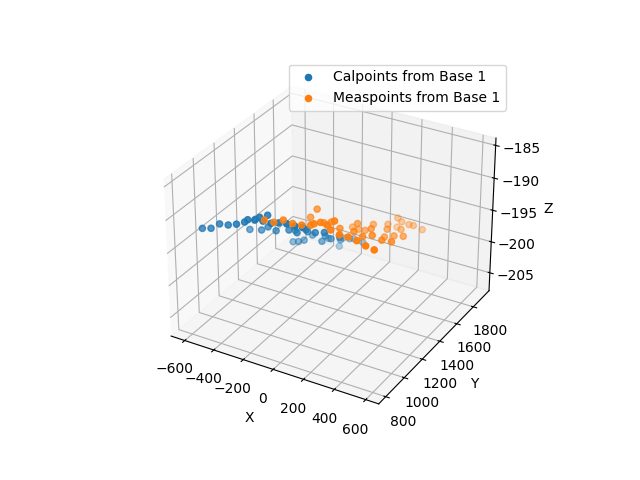

In [27]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_np[0][:,:,0][:, 0],data_np[0][:,:,0][:, 1], data_np[0][:,:,0][:, 2], 'bo-', label="Calpoints from Base 1")
ax.scatter(transformed[:, 0],transformed[:, 1], transformed[:, 2], 'ro-', label="Measpoints from Base 1")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

In [46]:
np.set_printoptions(suppress=True,precision=5)
print(np.array2string(data_np[0][:,:,0][:20], separator=', '))

[[  81.47215,  912.59351, -188.1876 ],
 [  25.30654,  921.76311, -188.49658],
 [ -31.99943,  929.31548, -188.6142 ],
 [ -88.01538,  935.50799, -188.92562],
 [-143.69417,  942.34528, -189.44698],
 [-199.08172,  946.08868, -189.51414],
 [-221.96082,  947.8621 , -189.12784],
 [-304.54517,  952.27246, -190.09111],
 [-325.88585,  952.69131, -190.57908],
 [-380.90264,  952.4514 , -191.26   ],
 [-436.92811,  952.39149, -191.75637],
 [-493.14353,  949.46962, -191.92687],
 [-550.79598,  946.58224, -192.9418 ],
 [-607.29581,  942.35765, -193.27495],
 [-218.36888, 1020.56647, -189.68625],
 [-303.95385, 1018.80664, -190.96384],
 [   1.59368, 1257.1821 , -193.79455],
 [ -50.1709 , 1242.88255, -193.99275],
 [-101.39593, 1227.77805, -193.69633],
 [-153.31964, 1214.1881 , -194.31966]]


In [47]:
np.set_printoptions(suppress=True,precision=5)
print(np.array2string(data_np[4][:,:,0][:20], separator=', '))

[[ 281.93664,  813.00075, -250.74397],
 [ 288.34131,  870.49538, -251.73428],
 [ 293.41198,  927.40449, -252.38056],
 [ 297.24915,  985.32172, -253.00191],
 [ 300.75906, 1041.42969, -254.78311],
 [ 301.89825, 1097.01864, -255.94245],
 [ 302.16366, 1120.89171, -256.10254],
 [ 303.54554, 1203.83093, -257.3186 ],
 [ 301.87726, 1224.21693, -257.64032],
 [ 298.93564, 1280.07093, -259.17647],
 [ 295.15539, 1337.05495, -259.86812],
 [ 290.83703, 1394.91061, -261.04597],
 [ 284.47419, 1451.03536, -261.72177],
 [ 277.81523, 1508.70015, -263.73126],
 [ 374.57264, 1119.75307, -255.87588],
 [ 369.31122, 1205.42748, -257.82582],
 [ 620.71386,  910.43542, -255.31016],
 [ 604.1015 ,  961.60691, -255.54973],
 [ 586.37211, 1012.08058, -256.4489 ],
 [ 571.55547, 1063.9743 , -257.45082]]


In [48]:
np.set_printoptions(suppress=True,precision=5)
print(np.array2string(data_np[0][:,:,0][20:], separator=', '))

[[-207.87512, 1215.38008, -194.28263],
 [-297.26761, 1218.22484, -195.03306],
 [-351.95246, 1219.07367, -194.80739],
 [-405.16202, 1231.01138, -195.79044],
 [-455.88826, 1245.34785, -194.63684],
 [-507.11798, 1260.9935 , -196.76062],
 [-200.32496, 1397.61538, -196.77651],
 [-289.09282, 1402.59325, -197.21549],
 [ -73.26635, 1540.97411, -198.64909],
 [-124.7113 , 1527.54575, -199.02501],
 [-175.3226 , 1509.43947, -199.54626],
 [-303.54526, 1517.28214, -200.32945],
 [-354.89916, 1536.33569, -201.13821],
 [-405.31879, 1555.45702, -201.75668],
 [-191.92911, 1571.85034, -199.60235],
 [-282.84564, 1576.22655, -200.10769],
 [-187.38123, 1733.17693, -202.23955],
 [-275.00872, 1738.19682, -202.63499],
 [-174.64673, 1862.91088, -203.5947 ],
 [-202.98186, 1861.15475, -203.76784],
 [-251.33852, 1864.22735, -204.00254],
 [-278.62449, 1866.19619, -203.78841],
 [-139.45496, 1908.37505, -204.52583],
 [-308.08844, 1914.4505 , -206.3994 ]]


In [49]:
np.set_printoptions(suppress=True,precision=5)
print(np.array2string(data_np[4][:,:,0][20:], separator=', '))

[[ 569.10267, 1118.60291, -257.56468],
 [ 568.07368, 1208.08206, -259.54461],
 [ 566.47553, 1263.97261, -260.15084],
 [ 577.33322, 1317.96399, -261.80079],
 [ 587.16032, 1368.9404 , -261.11007],
 [ 600.6998 , 1421.43631, -263.01739],
 [ 751.15622, 1119.77043, -258.17963],
 [ 751.71234, 1209.26045, -260.28662],
 [ 900.09291,  999.59905, -258.09521],
 [ 885.45842, 1050.84937, -258.76169],
 [ 864.81409, 1100.31313, -259.38147],
 [ 866.04916, 1229.52439, -262.13418],
 [ 881.4349 , 1282.11724, -262.84812],
 [ 898.63512, 1334.52785, -264.10237],
 [ 924.15218, 1119.93294, -259.35642],
 [ 923.9594 , 1211.02285, -261.30933],
 [1086.34755, 1124.61499, -260.52356],
 [1086.72317, 1211.95643, -262.19209],
 [1214.72143, 1117.79702, -260.00975],
 [1211.80278, 1144.89108, -261.40697],
 [1212.38867, 1194.47976, -262.74099],
 [1213.88515, 1221.53628, -262.98586],
 [1261.67549, 1083.8417 , -260.621  ],
 [1261.69426, 1254.48284, -263.4829 ]]


In [54]:
np.set_printoptions(suppress=True,precision=5)
print(np.array2string(data_np[4][:,:,0][[0,6,42,43]], separator=', '))

[[ 281.93664,  813.00075, -250.74397],
 [ 302.16366, 1120.89171, -256.10254],
 [1261.67549, 1083.8417 , -260.621  ],
 [1261.69426, 1254.48284, -263.4829 ]]


In [55]:
np.set_printoptions(suppress=True,precision=5)
print(np.array2string(data_np[0][:,:,0][[0,6,42,43]], separator=', '))

[[  81.47215,  912.59351, -188.1876 ],
 [-221.96082,  947.8621 , -189.12784],
 [-139.45496, 1908.37505, -204.52583],
 [-308.08844, 1914.4505 , -206.3994 ]]
